###### <center><h1>AR Modles- Dr.Milan Joshi (Lead Machine Learning Scientist - ReNew Power(Climate connect Digital)</h1></center>


## Syntax 

In [104]:
#from statsmodels.tsa.arima.model import ARIMA

# Define the order of the ARIMA model (p, d, q)
p = 1 # the number of autoregressive terms
d = 1 # the degree of differencing
q = 1 # the number of moving-average terms

# Instantiate the ARIMA model
#model = ARIMA(data, order=(p, d, q))

# Fit the ARIMA model
#results = model.fit()


## Importing the relevant packages


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

In [107]:
raw_csv_data = pd.read_csv("Index2018.csv")
raw_csv_data.head()


,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [108]:
raw_csv_data.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


In [109]:
raw_csv_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269 entries, 0 to 6268
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6269 non-null   object 
 1   spx     6269 non-null   float64
 2   dax     6269 non-null   float64
 3   ftse    6269 non-null   float64
 4   nikkei  6269 non-null   float64
dtypes: float64(4), object(1)
memory usage: 245.0+ KB


## Importing the Data and Pre-processing 

In [120]:
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
# Create a Boolean mask of missing values
missing_mask = df_comp.isna()

# Sum up the number of missing values for each column
missing_counts = missing_mask.sum()

# Print the missing value counts
print(missing_counts)
# print any missing dates
# set the date range
start_date = '1994-01-07'
end_date = '2018-01-29'
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = all_dates[~all_dates.isin(ftse.index)]
if len(missing_dates) > 0:
    print('Missing dates for ftse:')
    print(missing_dates)


spx       8
dax       8
ftse      8
nikkei    8
dtype: int64
Missing dates for ftse:
DatetimeIndex(['1994-01-08', '1994-01-09', '1994-01-15', '1994-01-16',
               '1994-01-22', '1994-01-23', '1994-01-29', '1994-01-30',
               '1994-02-05', '1994-02-06',
               ...
               '2018-01-01', '2018-01-06', '2018-01-07', '2018-01-13',
               '2018-01-14', '2018-01-20', '2018-01-21', '2018-01-27',
               '2018-01-28', '2018-01-29'],
              dtype='datetime64[ns]', length=2711, freq=None)


In [72]:
df_comp=df_comp.fillna(method='ffill')
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [114]:
# get the minimum and maximum dates
min_date = df_comp.index.min().strftime('%Y-%m-%d')
max_date = df_comp.index.max().strftime('%Y-%m-%d')

print('Minimum date:', min_date)
print('Maximum date:', max_date)




Minimum date: 1994-01-07
Maximum date: 2018-01-29


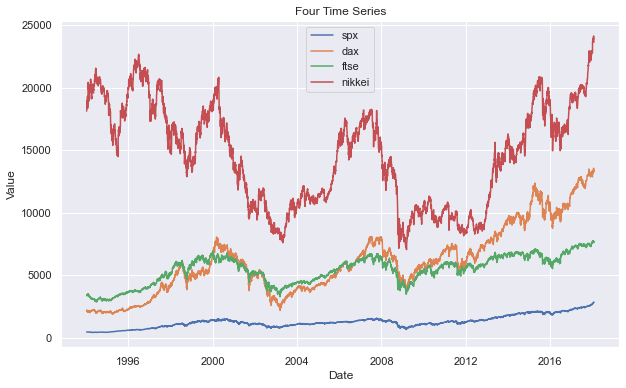

In [100]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each time series on the same axis
ax.plot(df_comp.index, df_comp['spx'], label='spx')
ax.plot(df_comp.index, df_comp['dax'], label='dax')
ax.plot(df_comp.index, df_comp['ftse'], label='ftse')
ax.plot(df_comp.index, df_comp['nikkei'], label='nikkei')

# Set the plot title and axis labels
ax.set_title('Four Time Series')
ax.set_xlabel('Date')
ax.set_ylabel('Value')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [68]:
df_comp['market_value']=df_comp.ftse

In [69]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
# Create Training and Testing Data
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [124]:
# plot the time series using Plotly Express
import plotly.express as px

fig = px.line(ftse, x=ftse.index, y='Close', title='FTSE Index')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=5, label="5day", step="day", stepmode="backward"),
            dict(count=10, label="10day", step="day", stepmode="backward"),
            dict(count=20, label="20day", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)


## The ACF

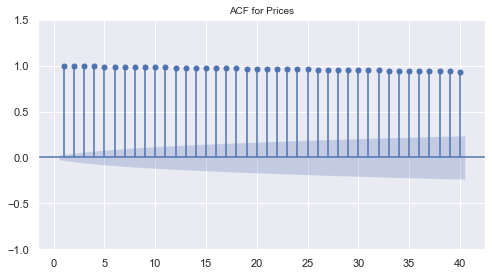

In [39]:
# Set the figure size and plot the ACF
fig, ax = plt.subplots(figsize=(7, 4))
sgt.plot_acf(df.market_value, zero=False, lags=40, ax=ax)
ax.set_title('ACF for Prices', size=10)
# Set the y-axis limit
ax.set_ylim(-1, 1.5)
# Adjust the layout to make sure the labels and axes are properly positioned
plt.tight_layout()

# Show the plot
plt.show()

When all 40 values in the autocorrelation function (ACF) plot are positive and all the lags are significant, this suggests that the time series exhibits a strong positive autocorrelation. In the context of an autoregressive (AR) model, this means that there is a strong dependence between the current value of the time series and its past values.

An AR model is a type of time series model that uses the past values of a time series to predict its future values. Specifically, an AR(p) model uses p past values of the time series to make a prediction for the next value. The parameter p is the order of the AR model, and it determines how many past values are used in the prediction.

When all values in the ACF plot are positive and significant, this suggests that an AR model may be a good fit for the time series. In this situation, the order of the AR model (i.e., the value of p) can be determined by looking at the partial autocorrelation function (PACF) plot. The PACF plot shows the correlation between the current value of the time series and its past values, after removing the effects of the intermediate values. The number of lags at which the PACF plot cuts off can be used to determine the order of the AR model.

In [7]:
import warnings
warnings.filterwarnings("ignore")

## The PACF

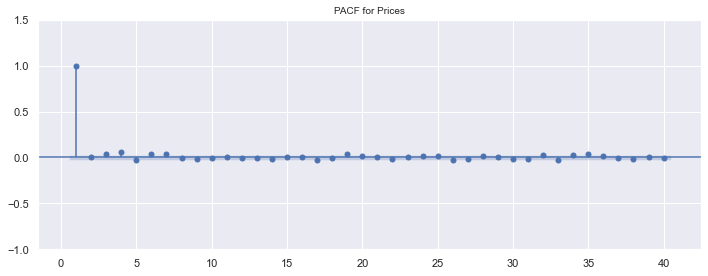

In [103]:
fig, ax = plt.subplots(figsize=(10, 4))
sgt.plot_pacf(df.market_value, zero=False, lags=40, ax=ax)
ax.set_title('PACF for Prices', size=10)
# Set the y-axis limit
ax.set_ylim(-1, 1.5)
# Adjust the layout to make sure the labels and axes are properly positioned
plt.tight_layout()

# Show the plot
plt.show()

## The AR(1) Model

In [12]:
model_ar = ARIMA(df.market_value,order=(1,0,0))

In [13]:
results_ar = model_ar.fit()

In [14]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27622.604
Date:                Sat, 18 Mar 2023   AIC                          55251.207
Time:                        19:22:30   BIC                          55270.772
Sample:                    01-07-1994   HQIC                         55258.063
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6374    423.329     12.023      0.000    4259.929    5919.346
ar.L1          0.9984      0.001   1147.578      0.000       0.997       1.000
sigma2      3511.3842     40.874     85.907      0.000    3431.272    3591.496
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              3313.33
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

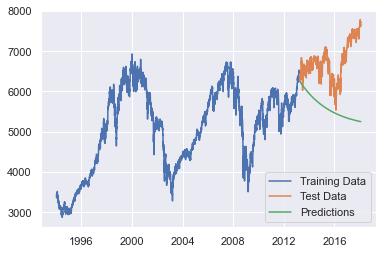

In [76]:
model_fit = model_ar.fit()

# Make predictions for the test set
predictions = model_fit.predict(start=len(df), end=len(df)+len(df_test)-1, dynamic=False)

# Plot the original data and the predictions
plt.plot(df.index, df['market_value'], label='Training Data')
plt.plot(df_test.index, df_test['market_value'], label='Test Data')
plt.plot(df_test.index, predictions, label='Predictions')
plt.legend()
plt.show()

Dep. Variable: market_value - This is the name of the dependent variable (or response variable) used in the model.

No. Observations: 5021 - This is the number of observations used in the model.

Model: ARIMA(1, 0, 0) - This indicates that the model used is an ARIMA model with 1 autoregressive (AR) term, 0 differencing (I) terms, and 0 moving average (MA) terms.

Log Likelihood -27622.604 - This is the maximized log-likelihood value of the model. Negative log-likelihood is  a measure of how well a statistical model fits the observed data, and it is the negative of the log-likelihood. A lower negative log-likelihood indicates a better fit between the model and the data.

AIC 55251.207 - This is the Akaike information criterion (AIC) value of the model. It is a measure of the relative quality of the model, with lower values indicating a better fit.

BIC 55270.772 - This is the Bayesian information criterion (BIC) value of the model. It is similar to the AIC but penalizes the number of parameters more strongly.

Sample: 01-07-1994 - This indicates the start date of the time series used in the model.

HQIC 55258.063 - This is the Hannan-Quinn information criterion (HQIC) value of the model, which is another measure of the relative quality of the model.

Covariance Type: opg - This is the type of covariance matrix used in the model. In this case, it is the “opg” (or “optimization-derived outer product of gradients”) method.

const 5089.6374 - This is the estimated value of the constant term in the model.

ar.L1 0.9984 - This is the estimated value of the AR coefficient in the model.

sigma2 3511.3842 - This is the estimated variance of the error term in the model.

Ljung-Box (L1) (Q): 1.51 - This is the Ljung-Box test statistic for testing the null hypothesis of no autocorrelation in the residuals up to lag 1. The p-value for this test is 0.22, indicating that there is no significant autocorrelation at lag 1.

Jarque-Bera (JB): 3313.33 - This is the Jarque-Bera test statistic for testing the null hypothesis of normality in the residuals. The p-value for this test is 0.00, indicating that the residuals are not normally distributed.

Prob(Q): 0.22 - This is the p-value for the Ljung-Box test.

Prob(JB): 0.00 - This is the p-value for the Jarque-Bera test.

Heteroskedasticity (H): 1.90 - This is the test statistic for testing the null hypothesis of homoscedasticity (constant variance) in the residuals. The p-value for this test is 0.00, indicating that there is evidence of heteroskedasticity in the residuals.

Skew: -0.18 - This is the skewness of the residuals, which is a measure of the symmetry of the distribution.

Prob(H) (two-sided): 0.00 - This is the p-value for the heteroskedasticity test.

Kurtosis: 6.96 - This is the kurtosis of the residuals, which is a measure of the “tailedness” of the distribution.

## Higher-Lag AR Models

In [125]:
model_ar_2 = ARIMA(df.market_value,order=(2,0,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -27621.949
Date:                Sun, 19 Mar 2023   AIC                          55251.898
Time:                        16:00:23   BIC                          55277.984
Sample:                    01-07-1994   HQIC                         55261.039
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    368.251     13.821      0.000    4367.881    5811.400
ar.L1          0.9811      0.010     99.868      0.000       0.962       1.000
ar.L2          0.0171      0.010      1.749      0.080      -0.002       0.036
sigma2      3510.1277     41.037     85.535      0.000    3429.696    3590.560
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3282.81
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

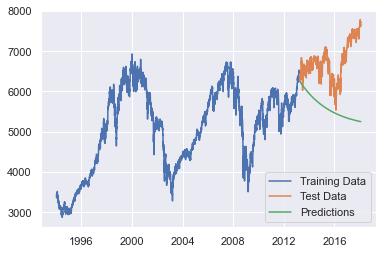

In [77]:
model_fit = model_ar_2.fit()

# Make predictions for the test set
predictions = model_fit.predict(start=len(df), end=len(df)+len(df_test)-1, dynamic=False)

# Plot the original data and the predictions
plt.plot(df.index, df['market_value'], label='Training Data')
plt.plot(df_test.index, df_test['market_value'], label='Test Data')
plt.plot(df_test.index, predictions, label='Predictions')
plt.legend()
plt.show()

In [41]:
model_ar_3 = ARIMA(df.market_value,order=(3,0,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -27615.962
Date:                Sat, 18 Mar 2023   AIC                          55241.925
Time:                        19:51:53   BIC                          55274.532
Sample:                    01-07-1994   HQIC                         55253.351
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    378.583     13.444      0.000    4347.631    5831.651
ar.L1          0.9802      0.010     99.076      0.000       0.961       1.000
ar.L2         -0.0309      0.013     -2.315      0.021      -0.057      -0.005
ar.L3          0.0489      0.009      5.383      0.000       0.031       0.067
sigma2      3502.2643     41.020     85.379      0.000    3421.866    3582.662
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3286.97
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

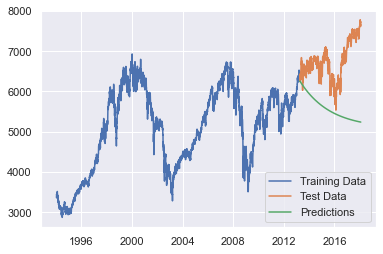

In [78]:
model_fit = model_ar_3.fit()

# Make predictions for the test set
predictions = model_fit.predict(start=len(df), end=len(df)+len(df_test)-1, dynamic=False)

# Plot the original data and the predictions
plt.plot(df.index, df['market_value'], label='Training Data')
plt.plot(df_test.index, df_test['market_value'], label='Test Data')
plt.plot(df_test.index, predictions, label='Predictions')
plt.legend()
plt.show()

In [42]:
model_ar_4 = ARIMA(df.market_value,order=(4,0,0))
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -27602.680
Date:                Sat, 18 Mar 2023   AIC                          55217.359
Time:                        19:52:06   BIC                          55256.488
Sample:                    01-07-1994   HQIC                         55231.070
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    391.959     12.985      0.000    4321.416    5857.866
ar.L1          0.9767      0.010     97.788      0.000       0.957       0.996
ar.L2         -0.0287      0.013     -2.129      0.033      -0.055      -0.002
ar.L3         -0.0224      0.013     -1.784      0.074      -0.047       0.002
ar.L4          0.0728      0.009      8.033      0.000       0.055       0.091
sigma2      3484.0262     41.922     83.108      0.000    3401.861    3566.191
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3044.18
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

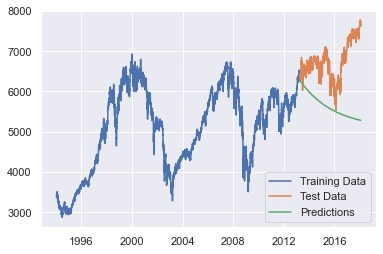

In [79]:
model_fit = model_ar_4.fit()

# Make predictions for the test set
predictions = model_fit.predict(start=len(df), end=len(df)+len(df_test)-1, dynamic=False)

# Plot the original data and the predictions
plt.plot(df.index, df['market_value'], label='Training Data')
plt.plot(df_test.index, df_test['market_value'], label='Test Data')
plt.plot(df_test.index, predictions, label='Predictions')
plt.legend()
plt.show()

**The LLR (Log-Likelihood Ratio** test is a statistical test used to compare the fit of two nested models, where one model is a restricted version of the other. The LLR test is commonly used in time series analysis to compare the fit of two autoregressive (AR) models.

The general steps to perform an LLR test for time series comparison are as follows:

Fit the two AR models: First, we fit the two AR models that we want to compare. Let's call these models AR(p) and AR(q), where p is the order of the first model and q is the order of the second model.

Calculate the log-likelihoods: Calculate the log-likelihoods of each model using the same dataset. The log-likelihood measures how well the model fits the data, with higher values indicating a better fit.

Calculate the LLR statistic: Calculate the LLR statistic as the difference between the log-likelihoods of the two models: LLR = 2 * (log-likelihood of AR(p) - log-likelihood of AR(q)).

Calculate the degrees of freedom: Calculate the degrees of freedom as the difference in the number of parameters between the two models: df = p - q.

Calculate the p-value: Calculate the p-value for the LLR statistic using the chi-square distribution with degrees of freedom df: p-value = 1 - chi2.cdf(LLR, df).

Compare the p-value to the significance level: Compare the p-value to a chosen significance level (e.g., 0.05). If the p-value is less than the significance level, then we reject the null hypothesis that the two models have the same fit, and we conclude that the model with the higher log-likelihood is a better fit to the data.

In summary, the LLR test is a useful tool for comparing the fit of two nested AR models. The test helps us to determine which model has a better fit to the data, and thus is a more appropriate model for forecasting future values.

## LLR Test

In [43]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## Comparing Higher-Lag AR Models

In [44]:
LLR_test(model_ar_2, model_ar_3)

0.0

In [45]:
LLR_test(model_ar_3, model_ar_4)

0.0

In [47]:
model_ar_4 = ARIMA(df.market_value,order=(4,0,0))
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary()) 
print ("LLR test: " + str(LLR_test(model_ar_3, model_ar_4)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -27602.680
Date:                Sat, 18 Mar 2023   AIC                          55217.359
Time:                        19:52:40   BIC                          55256.488
Sample:                    01-07-1994   HQIC                         55231.070
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    391.959     12.985      0.000    4321.416    5857.866
ar.L1          0.9767      0.010     97.788      0.000       0.957       0.996
ar.L2         -0.0287      0.013     -2.129      0.0

In [126]:
model_ar_5 = ARIMA(df.market_value,order=(5,0,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_4, model_ar_5)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -27600.460
Date:                Sun, 19 Mar 2023   AIC                          55214.920
Time:                        16:10:52   BIC                          55260.570
Sample:                    01-07-1994   HQIC                         55230.916
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    386.229     13.178      0.000    4332.646    5846.636
ar.L1          0.9788      0.010     97.867      0.000       0.959       0.998
ar.L2         -0.0293      0.013     -2.176      0.0

In [49]:
model_ar_6 = ARIMA(df.market_value,order=(6,0,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_5, model_ar_6)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 0)   Log Likelihood              -27596.587
Date:                Sat, 18 Mar 2023   AIC                          55209.174
Time:                        19:53:10   BIC                          55261.345
Sample:                    01-07-1994   HQIC                         55227.455
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    396.932     12.822      0.000    4311.669    5867.612
ar.L1          0.9800      0.010     96.873      0.000       0.960       1.000
ar.L2         -0.0333      0.014     -2.438      0.0

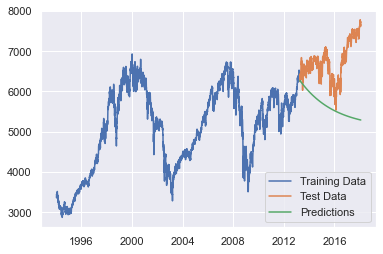

In [80]:
model_fit = model_ar_6.fit()

# Make predictions for the test set
predictions = model_fit.predict(start=len(df), end=len(df)+len(df_test)-1, dynamic=False)

# Plot the original data and the predictions
plt.plot(df.index, df['market_value'], label='Training Data')
plt.plot(df_test.index, df_test['market_value'], label='Test Data')
plt.plot(df_test.index, predictions, label='Predictions')
plt.legend()
plt.show()

In [83]:
model_ar_7 = ARIMA(df.market_value,order=(7,0,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_6, model_ar_7)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -27592.022
Date:                Sat, 18 Mar 2023   AIC                          55202.044
Time:                        20:08:42   BIC                          55260.736
Sample:                    01-07-1994   HQIC                         55222.610
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    405.380     12.555      0.000    4295.111    5884.171
ar.L1          0.9783      0.010     95.742      0.000       0.958       0.998
ar.L2         -0.0304      0.014     -2.183      0.0

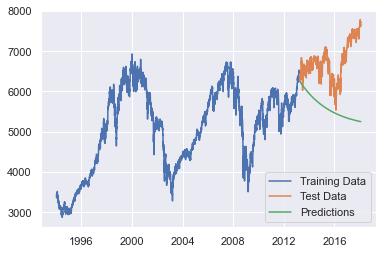

In [81]:
model_fit = model_ar_7.fit()

# Make predictions for the test set
predictions = model_fit.predict(start=len(df), end=len(df)+len(df_test)-1, dynamic=False)

# Plot the original data and the predictions
plt.plot(df.index, df['market_value'], label='Training Data')
plt.plot(df_test.index, df_test['market_value'], label='Test Data')
plt.plot(df_test.index, predictions, label='Predictions')
plt.legend()
plt.show()

In [84]:
model_ar_8 = ARIMA(df.market_value,order=(8,0,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_7, model_ar_8)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -27591.854
Date:                Sat, 18 Mar 2023   AIC                          55203.708
Time:                        20:08:52   BIC                          55268.922
Sample:                    01-07-1994   HQIC                         55226.560
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    407.243     12.498      0.000    4291.460    5887.822
ar.L1          0.9787      0.010     95.719      0.000       0.959       0.999
ar.L2         -0.0305      0.014     -2.183      0.0

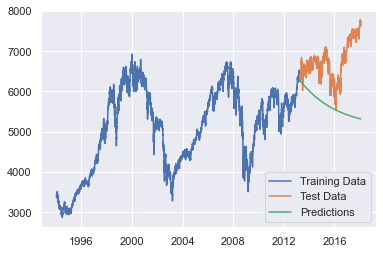

In [85]:
model_fit = model_ar_8.fit()

# Make predictions for the test set
predictions = model_fit.predict(start=len(df), end=len(df)+len(df_test)-1, dynamic=False)

# Plot the original data and the predictions
plt.plot(df.index, df['market_value'], label='Training Data')
plt.plot(df_test.index, df_test['market_value'], label='Test Data')
plt.plot(df_test.index, predictions, label='Predictions')
plt.legend()
plt.show()

In [53]:
print("LLR test: " + str(LLR_test(model_ar, model_ar_7, DF = 6)))

LLR test: 1.0


## Analysing the Residuals

In [90]:
df['res_price'] = results_ar_7.resid

In [91]:
df.res_price.mean()

0.3519708988091798

In [92]:
df.res_price.var()

4005.8220458241262

In [93]:
sts.adfuller(df.res_price)

(-76.05339410895732,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 54842.15874022142)

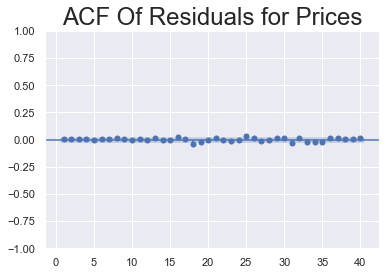

In [94]:
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

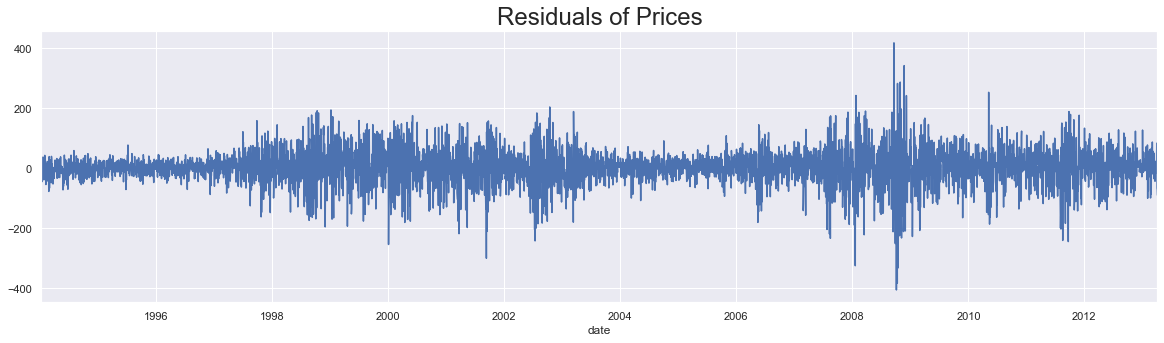

In [95]:
df.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()

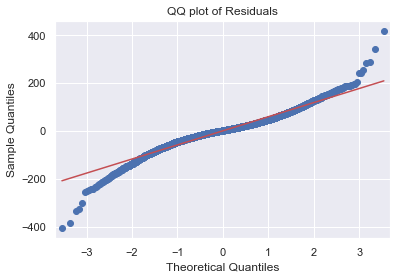

In [97]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create a QQ plot of the residuals
fig = sm.graphics.qqplot(df.res_price[1:], line='s')

# Set the plot title
plt.title('QQ plot of Residuals')

# Show the plot
plt.show()
